In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy.optimize import curve_fit
from sympy import symbols, diff, lambdify
import os
from matplotlib.ticker import FuncFormatter

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

def chf_formatter(x, pos):
    return f'CHF {int(x):,}'.replace(',', "'")

np.random.seed(42)

In [2]:
with open('../../data/processed/swiss_rental_data_m2_room_count/Durchscnittlicher_Mietpreis_m2_Zimmerzahl_Kanton_combined.json', 'r', encoding='utf-8') as f:
    room_data = json.load(f)

with open('../../data/processed/swiss_rental_data_m2_construction_period/Durchschnittlicher_Mietpreis_m2_Bauperiode_Kanton_combined.json', 'r', encoding='utf-8') as f:
    construction_data = json.load(f)

print(f"Loaded data for rooms: {len(room_data)} entries")
print(f"Loaded data for construction periods: {len(construction_data)} entries")

Loaded data for rooms: 324 entries
Loaded data for construction periods: 324 entries


In [3]:
def flatten_room_data(json_data):
    flat_data = {
        "year": [],
        "canton": [],
        "room_count": [],
        "avg_price_per_sqm": [],
        "confidence_interval": []
    }

    for item in json_data:
        for room in item.get("room_categories", []):
            flat_data["year"].append(item.get("year"))
            flat_data["canton"].append(item.get("canton"))
            flat_data["room_count"].append(room.get("room_count"))
            flat_data["avg_price_per_sqm"].append(room.get("avg_price_per_sqm"))
            flat_data["confidence_interval"].append(room.get("confidence_interval"))

    return pd.DataFrame(flat_data)

def flatten_construction_data(json_data):
    flat_data = {
        "year": [],
        "canton": [],
        "construction_period": [],
        "avg_price_per_sqm": [],
        "confidence_interval": []
    }

    for item in json_data:
        for period in item.get("construction_periods", []):
            flat_data["year"].append(item.get("year"))
            flat_data["canton"].append(item.get("canton"))
            flat_data["construction_period"].append(period.get("construction_period"))
            flat_data["avg_price_per_sqm"].append(period.get("avg_price_per_sqm"))
            flat_data["confidence_interval"].append(period.get("confidence_interval"))

    return pd.DataFrame(flat_data)

In [4]:
room_df = flatten_room_data(room_data)
construction_df = flatten_construction_data(construction_data)

room_df['year'] = pd.to_numeric(room_df['year'], errors='ignore')
construction_df['year'] = pd.to_numeric(construction_df['year'], errors='ignore')

room_df['room_count_num'] = room_df['room_count'].apply(
    lambda x: float(str(x).replace('+', '')) if pd.notna(x) else np.nan
)

print("Room count dataset summary:")
print(f"Years included: {sorted(room_df['year'].unique())}")
print(f"Number of cantons: {room_df['canton'].nunique()}")
print(f"Room categories: {sorted(room_df['room_count'].unique())}")
print(f"Total data points: {len(room_df)}")
print("\n")

print("Construction period dataset summary:")
print(f"Years included: {sorted(construction_df['year'].unique())}")
print(f"Number of cantons: {construction_df['canton'].nunique()}")
print(f"Construction periods: {sorted(construction_df['construction_period'].unique())}")
print(f"Total data points: {len(construction_df)}")

Room count dataset summary:
Years included: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
Number of cantons: 27
Room categories: ['1', '2', '3', '4', '5', '6+']
Total data points: 1930


Construction period dataset summary:
Years included: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
Number of cantons: 27
Construction periods: ['1919 - 1945', '1946 - 1960', '1961 - 1970', '1971 - 1980', '1981 - 1990', '1991 - 2000', '2001-2010', '2001-2012', '2001-2013', '2011-2014', '2011-2015', '2011-2016', '2011-2017', '2011-2018', '2011-2019', '2011-2020', '2011-2021', '2011-2022', '2021-2023', 'Total', 'Vor 1919']
Total data points: 3201


C:\Users\Nevin\AppData\Local\Temp\ipykernel_7404\3718349989.py:4: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  room_df['year'] = pd.to_numeric(room_df['year'], errors='ignore')
C:\Users\Nevin\AppData\Local\Temp\ipykernel_7404\3718349989.py:5: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  construction_df['year'] = pd.to_numeric(construction_df['year'], errors='ignore')


In [5]:
print("Summary statistics for room count dataset (price per m²):")
display(room_df['avg_price_per_sqm'].describe())

print("\nSummary statistics for construction period dataset (price per m²):")
display(construction_df['avg_price_per_sqm'].describe())

Summary statistics for room count dataset (price per m²):


count    1930.000000
mean       15.427202
std         2.849014
min         7.100000
25%        13.400000
50%        14.900000
75%        17.200000
max        27.400000
Name: avg_price_per_sqm, dtype: float64


Summary statistics for construction period dataset (price per m²):


count    3201.000000
mean       15.288691
std         2.490907
min         9.400000
25%        13.500000
50%        14.800000
75%        16.800000
max        27.300000
Name: avg_price_per_sqm, dtype: float64

In [6]:
latest_room_year = max(room_df['year'])
latest_construction_year = max(construction_df['year'])

print(f"\nUsing data from year {latest_room_year} for room analysis")
print(f"Using data from year {latest_construction_year} for construction period analysis")

room_latest = room_df[room_df['year'] == latest_room_year]
construction_latest = construction_df[construction_df['year'] == latest_construction_year]


Using data from year 2023 for room analysis
Using data from year 2023 for construction period analysis


C:\Users\Nevin\AppData\Local\Temp\ipykernel_7404\266209129.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='room_count', y='avg_price_per_sqm',


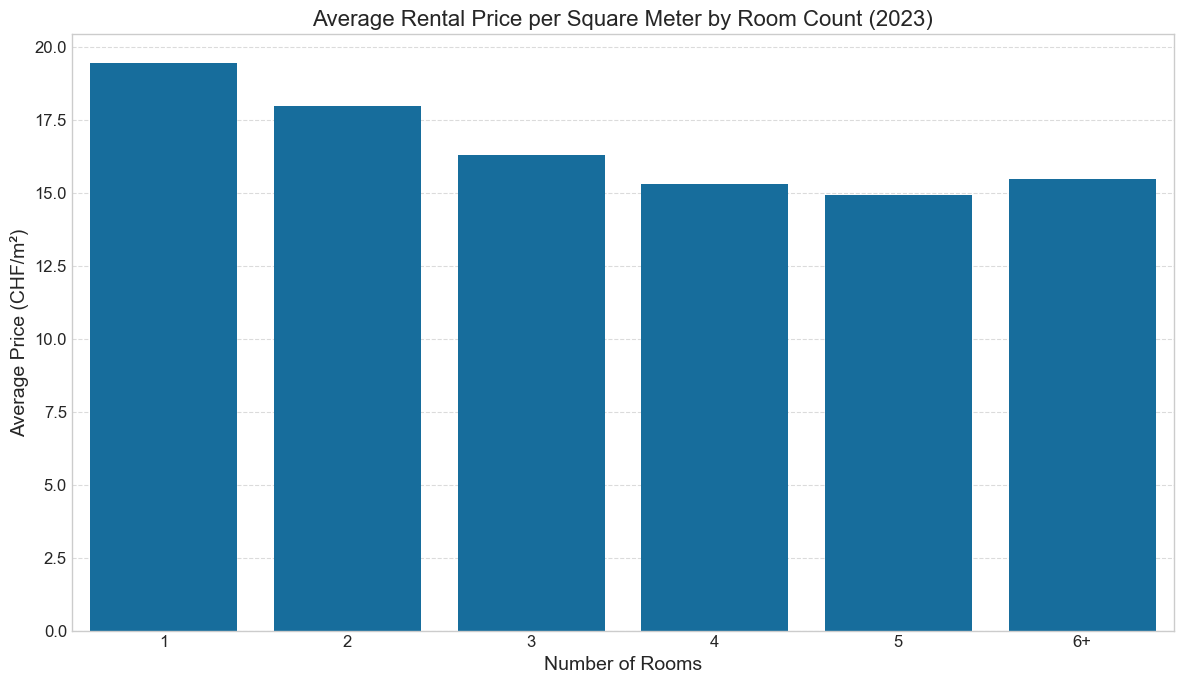

Correlation between number of rooms and price per m²: -0.9007


In [7]:
plt.figure(figsize=(12, 7))

room_order = sorted(room_latest['room_count'].unique(), 
                   key=lambda x: float(str(x).replace('+', '')) if str(x).replace('+', '').isdigit() else 999)

sns.barplot(x='room_count', y='avg_price_per_sqm', 
            data=room_latest, 
            order=room_order,
            ci=None)

plt.title(f'Average Rental Price per Square Meter by Room Count ({latest_room_year})', fontsize=16)
plt.xlabel('Number of Rooms', fontsize=14)
plt.ylabel('Average Price (CHF/m²)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

room_avg = room_latest.groupby('room_count_num')['avg_price_per_sqm'].mean().reset_index()
room_corr = room_avg['room_count_num'].corr(room_avg['avg_price_per_sqm'])
print(f"Correlation between number of rooms and price per m²: {room_corr:.4f}")

C:\Users\Nevin\AppData\Local\Temp\ipykernel_7404\290230026.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='construction_period', y='avg_price_per_sqm',


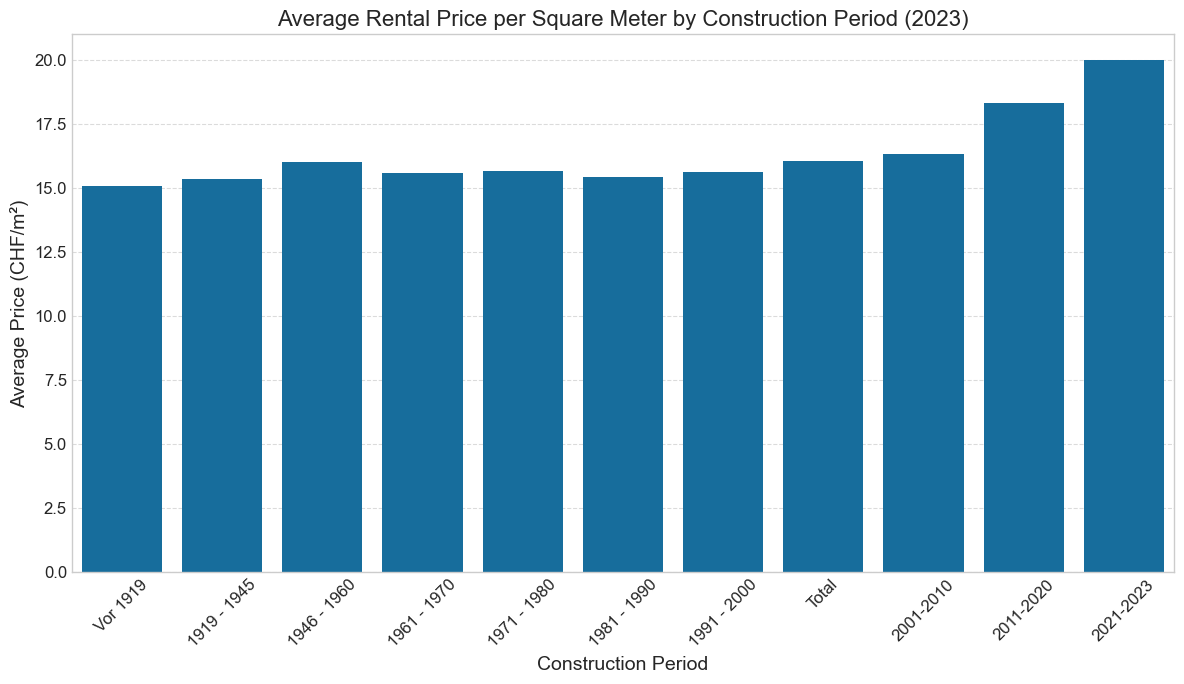

Modern construction periods: ['2001-2010', '2011-2020']
Old construction periods: ['Vor 1919', '1919 - 1945', '1946 - 1960']


In [8]:
plt.figure(figsize=(12, 7))

period_order = sorted(construction_latest['construction_period'].unique(), 
                     key=lambda x: int(x.split('-')[0]) if '-' in x else 
                     (1900 if 'vor' in x.lower() else 
                      (2100 if 'nach' in x.lower() or 'ab' in x.lower() else 2000)))

sns.barplot(x='construction_period', y='avg_price_per_sqm', 
            data=construction_latest, 
            order=period_order,
            ci=None)

plt.title(f'Average Rental Price per Square Meter by Construction Period ({latest_construction_year})', fontsize=16)
plt.xlabel('Construction Period', fontsize=14)
plt.ylabel('Average Price (CHF/m²)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

modern_periods = [p for p in period_order if any(x in p for x in ['2001', '2010', '2020', 'nach'])]
old_periods = [p for p in period_order if any(x in p for x in ['vor', '1919', '1945', '1960'])]

print("Modern construction periods:", modern_periods)
print("Old construction periods:", old_periods)

In [9]:
if modern_periods and old_periods:
    modern_price = construction_latest[construction_latest['construction_period'].isin(modern_periods)]['avg_price_per_sqm'].mean()
    old_price = construction_latest[construction_latest['construction_period'].isin(old_periods)]['avg_price_per_sqm'].mean()

    print(f"Average price for modern buildings: CHF {modern_price:.2f} per m²")
    print(f"Average price for old buildings: CHF {old_price:.2f} per m²")
    print(f"Price difference: CHF {modern_price - old_price:.2f} per m² ({(modern_price/old_price - 1)*100:.1f}%)")

Average price for modern buildings: CHF 17.32 per m²
Average price for old buildings: CHF 15.46 per m²
Price difference: CHF 1.85 per m² (12.0%)


In [10]:
typical_sizes = {
    '1': 35,
    '2': 55,
    '3': 75,
    '4': 95,
    '5': 120,
    '5+': 130,
    '6': 150,
    '6+': 160
}

cost_data = []

for room_group in room_latest.groupby('room_count'):
    room_count = room_group[0]
    avg_price = room_group[1]['avg_price_per_sqm'].mean()

    if room_count in typical_sizes:
        size = typical_sizes[room_count]
        total_rent = avg_price * size
        cost_data.append({
            'room_count': room_count,
            'room_count_num': float(str(room_count).replace('+', '')),
            'apartment_size': size,
            'price_per_sqm': avg_price,
            'total_monthly_rent': total_rent
        })

cost_df = pd.DataFrame(cost_data)
cost_df = cost_df.sort_values('apartment_size')

print("Estimated apartment sizes and monthly rents:")
display(cost_df)

Estimated apartment sizes and monthly rents:


,room_count,room_count_num,apartment_size,price_per_sqm,total_monthly_rent
0,1,1.0,35,19.442308,680.480769
1,2,2.0,55,17.970370,988.370370
2,3,3.0,75,16.270370,1220.277778
3,4,4.0,95,15.288889,1452.444444
4,5,5.0,120,14.914815,1789.777778
5,6+,6.0,160,15.459259,2473.481481


Original fitted parameters: a = 0.022083, b = 9.6461, c = 349.20
Generalized parameters: a = 0.022, b = 9.6, c = 349


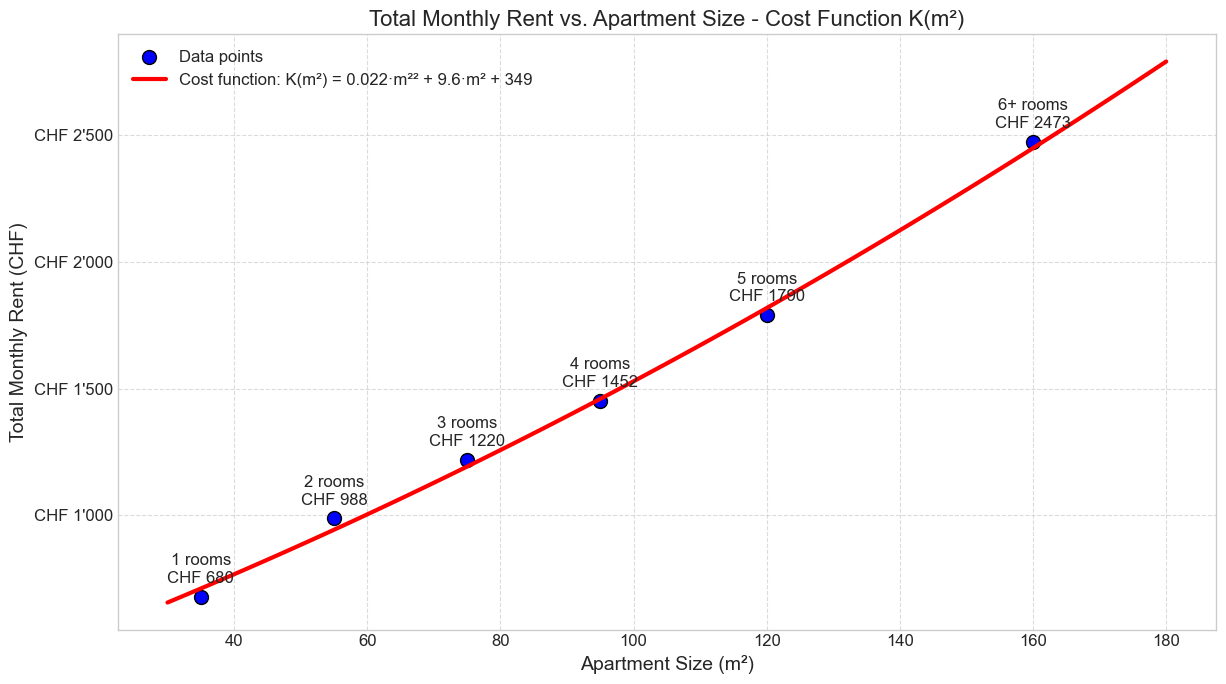

R² value for the generalized cost function: 0.9974


In [11]:
plt.figure(figsize=(12, 7))

plt.scatter(cost_df['apartment_size'], cost_df['total_monthly_rent'], 
            s=100, color='blue', edgecolor='black', label='Data points')

for i, row in cost_df.iterrows():
    plt.annotate(f"{row['room_count']} rooms\nCHF {row['total_monthly_rent']:.0f}", 
               (row['apartment_size'], row['total_monthly_rent']),
               textcoords="offset points", 
               xytext=(0, 10), 
               ha='center')

def cost_function(x, a, b, c):
    return a * x**2 + b * x + c

params, covariance = curve_fit(cost_function, 
                              cost_df['apartment_size'], 
                              cost_df['total_monthly_rent'])

a_original, b_original, c_original = params

a = round(a_original, 3)
b = round(b_original, 1)
c = round(c_original, 0)

print(f"Original fitted parameters: a = {a_original:.6f}, b = {b_original:.4f}, c = {c_original:.2f}")
print(f"Generalized parameters: a = {a:.3f}, b = {b:.1f}, c = {c:.0f}")

x_fit = np.linspace(min(cost_df['apartment_size']) - 5, max(cost_df['apartment_size']) + 20, 100)
y_fit = cost_function(x_fit, a, b, c)

plt.plot(x_fit, y_fit, 'r-', linewidth=3, 
         label=f'Cost function: K(m²) = {a:.3f}·m²² + {b:.1f}·m² + {c:.0f}')

plt.title('Total Monthly Rent vs. Apartment Size - Cost Function K(m²)', fontsize=16)
plt.xlabel('Apartment Size (m²)', fontsize=14)
plt.ylabel('Total Monthly Rent (CHF)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()

plt.gca().yaxis.set_major_formatter(FuncFormatter(chf_formatter))

plt.show()

y_actual = cost_df['total_monthly_rent']
y_pred = cost_function(cost_df['apartment_size'], a, b, c)
ss_total = np.sum((y_actual - np.mean(y_actual))**2)
ss_residual = np.sum((y_actual - y_pred)**2)
r_squared = 1 - (ss_residual / ss_total)

print(f"R² value for the generalized cost function: {r_squared:.4f}")

In [12]:
x = symbols('x')

cost_func_sym = a * x**2 + b * x + c

marginal_cost_sym = diff(cost_func_sym, x)

print(f"Cost function K(m²): {cost_func_sym}")
print(f"Marginal cost function K'(m²): {marginal_cost_sym}")

marginal_cost_func = lambdify(x, marginal_cost_sym, 'numpy')

marginal_costs = marginal_cost_func(cost_df['apartment_size'])
cost_df['marginal_cost'] = marginal_costs

print("\nMarginal cost at different apartment sizes:")
display(cost_df[['room_count', 'apartment_size', 'price_per_sqm', 'marginal_cost']])

Cost function K(m²): 0.022*x**2 + 9.6*x + 349.0
Marginal cost function K'(m²): 0.044*x + 9.6

Marginal cost at different apartment sizes:


,room_count,apartment_size,price_per_sqm,marginal_cost
0,1,35,19.442308,11.14
1,2,55,17.970370,12.02
2,3,75,16.270370,12.90
3,4,95,15.288889,13.78
4,5,120,14.914815,14.88
5,6+,160,15.459259,16.64


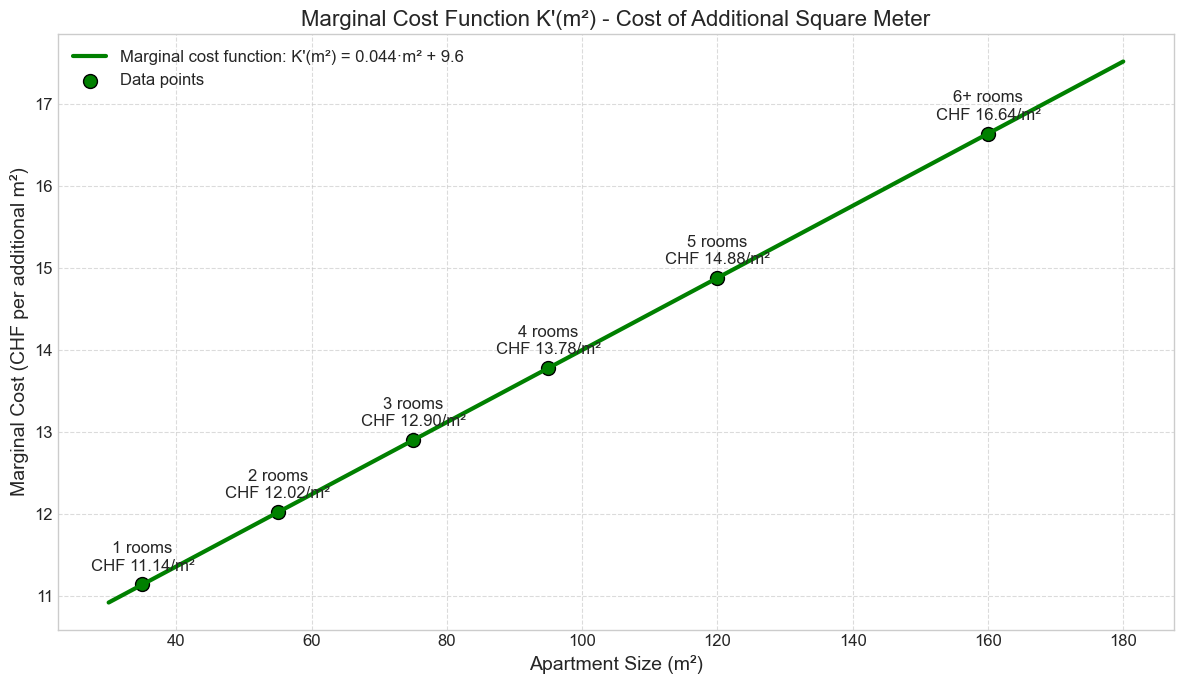

In [13]:
plt.figure(figsize=(12, 7))

plt.plot(x_fit, marginal_cost_func(x_fit), 'g-', linewidth=3, 
         label=f"Marginal cost function: K'(m²) = {2*a:.3f}·m² + {b:.1f}")

plt.scatter(cost_df['apartment_size'], cost_df['marginal_cost'], 
            s=100, color='green', edgecolor='black', label='Data points')

for i, row in cost_df.iterrows():
    plt.annotate(f"{row['room_count']} rooms\nCHF {row['marginal_cost']:.2f}/m²", 
               (row['apartment_size'], row['marginal_cost']),
               textcoords="offset points", 
               xytext=(0, 10), 
               ha='center')

plt.title('Marginal Cost Function K\'(m²) - Cost of Additional Square Meter', fontsize=16)
plt.xlabel('Apartment Size (m²)', fontsize=14)
plt.ylabel('Marginal Cost (CHF per additional m²)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

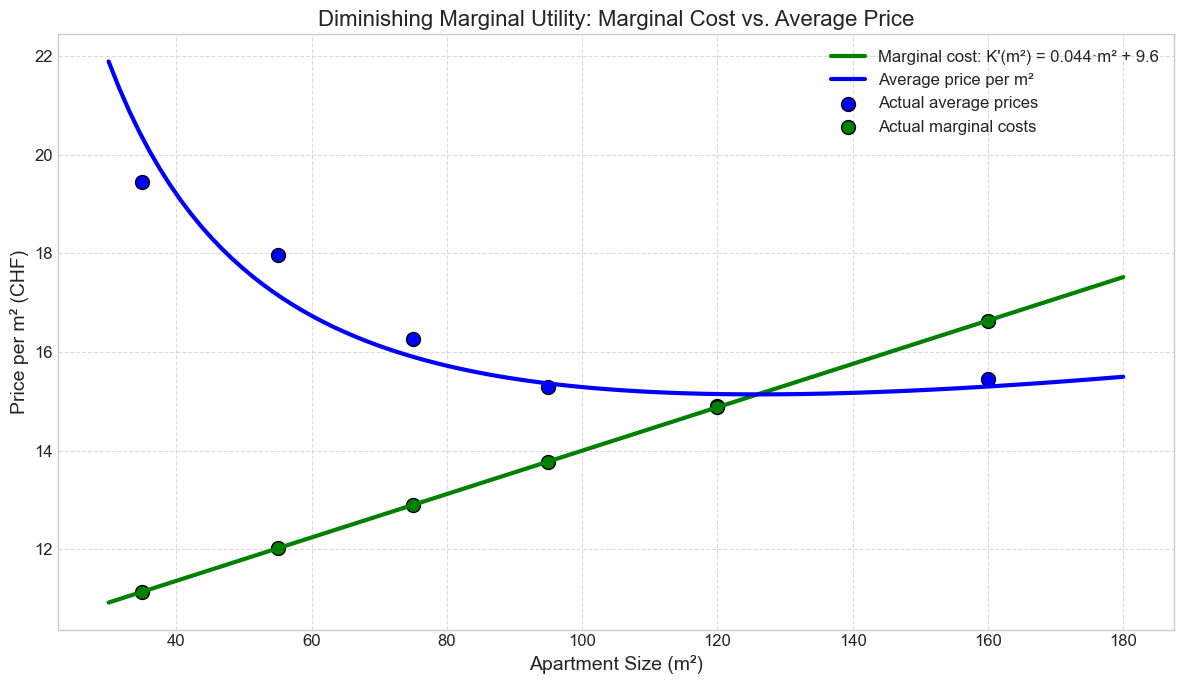

Comparison of marginal cost vs. average price per m²:


,room_count,apartment_size,price_per_sqm,marginal_cost,avg_price_diff,avg_price_ratio
0,1,35,19.442308,11.14,-8.302308,0.572977
1,2,55,17.970370,12.02,-5.950370,0.668879
2,3,75,16.270370,12.90,-3.370370,0.792852
3,4,95,15.288889,13.78,-1.508889,0.901308
4,5,120,14.914815,14.88,-0.034815,0.997666
5,6+,160,15.459259,16.64,1.180741,1.076378


In [14]:
plt.figure(figsize=(12, 7))

plt.plot(x_fit, marginal_cost_func(x_fit), 'g-', linewidth=3, 
         label=f"Marginal cost: K'(m²) = {2*a:.3f}·m² + {b:.1f}")

def avg_price_function(x, a, b, c):
    return (a * x**2 + b * x + c) / x

avg_prices = np.array([avg_price_function(size, a, b, c) for size in x_fit])
plt.plot(x_fit, avg_prices, 'b-', linewidth=3, 
         label='Average price per m²')

plt.scatter(cost_df['apartment_size'], cost_df['price_per_sqm'], 
            s=100, color='blue', edgecolor='black', label='Actual average prices')
plt.scatter(cost_df['apartment_size'], cost_df['marginal_cost'], 
            s=100, color='green', edgecolor='black', label='Actual marginal costs')

plt.title('Diminishing Marginal Utility: Marginal Cost vs. Average Price', fontsize=16)
plt.xlabel('Apartment Size (m²)', fontsize=14)
plt.ylabel('Price per m² (CHF)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

cost_df['avg_price_diff'] = cost_df['marginal_cost'] - cost_df['price_per_sqm']
cost_df['avg_price_ratio'] = cost_df['marginal_cost'] / cost_df['price_per_sqm']

print("Comparison of marginal cost vs. average price per m²:")
display(cost_df[['room_count', 'apartment_size', 'price_per_sqm', 'marginal_cost', 'avg_price_diff', 'avg_price_ratio']])

In [15]:
new_periods = [p for p in construction_latest['construction_period'].unique() 
              if any(x in p for x in ['2001', '2010', '2020', 'nach'])]
old_periods = [p for p in construction_latest['construction_period'].unique() 
              if any(x in p for x in ['vor', '1919', '1945', '1960'])]

new_buildings = construction_latest[construction_latest['construction_period'].isin(new_periods)]
old_buildings = construction_latest[construction_latest['construction_period'].isin(old_periods)]

new_avg_by_canton = new_buildings.groupby('canton')['avg_price_per_sqm'].mean().reset_index()
old_avg_by_canton = old_buildings.groupby('canton')['avg_price_per_sqm'].mean().reset_index()

comparison_df = pd.merge(new_avg_by_canton, old_avg_by_canton, 
                        on='canton', suffixes=('_new', '_old'))
comparison_df['price_diff'] = comparison_df['avg_price_per_sqm_new'] - comparison_df['avg_price_per_sqm_old']
comparison_df['price_ratio'] = comparison_df['avg_price_per_sqm_new'] / comparison_df['avg_price_per_sqm_old']
comparison_df = comparison_df.sort_values('price_diff', ascending=False)

print("Comparison of prices between new and old buildings by canton:")
display(comparison_df)

Comparison of prices between new and old buildings by canton:


,canton,avg_price_per_sqm_new,avg_price_per_sqm_old,price_diff,price_ratio
4,Basel-Stadt,22.45,18.366667,4.083333,1.222323
12,Neuenburg,16.25,12.866667,3.383333,1.262953
3,Basel-Landschaft,19.70,16.566667,3.133333,1.189135
9,Graubünden,17.65,14.666667,2.983333,1.203409
17,Schwyz,18.50,15.633333,2.866667,1.183369
1,Appenzell A.Rh.,15.70,12.833333,2.866667,1.223377
23,Waadt,20.90,18.233333,2.666667,1.146252
21,Thurgau,15.85,13.300000,2.550000,1.191729
15,Schaffhausen,16.50,13.966667,2.533333,1.181384
8,Glarus,15.25,12.800000,2.450000,1.191406


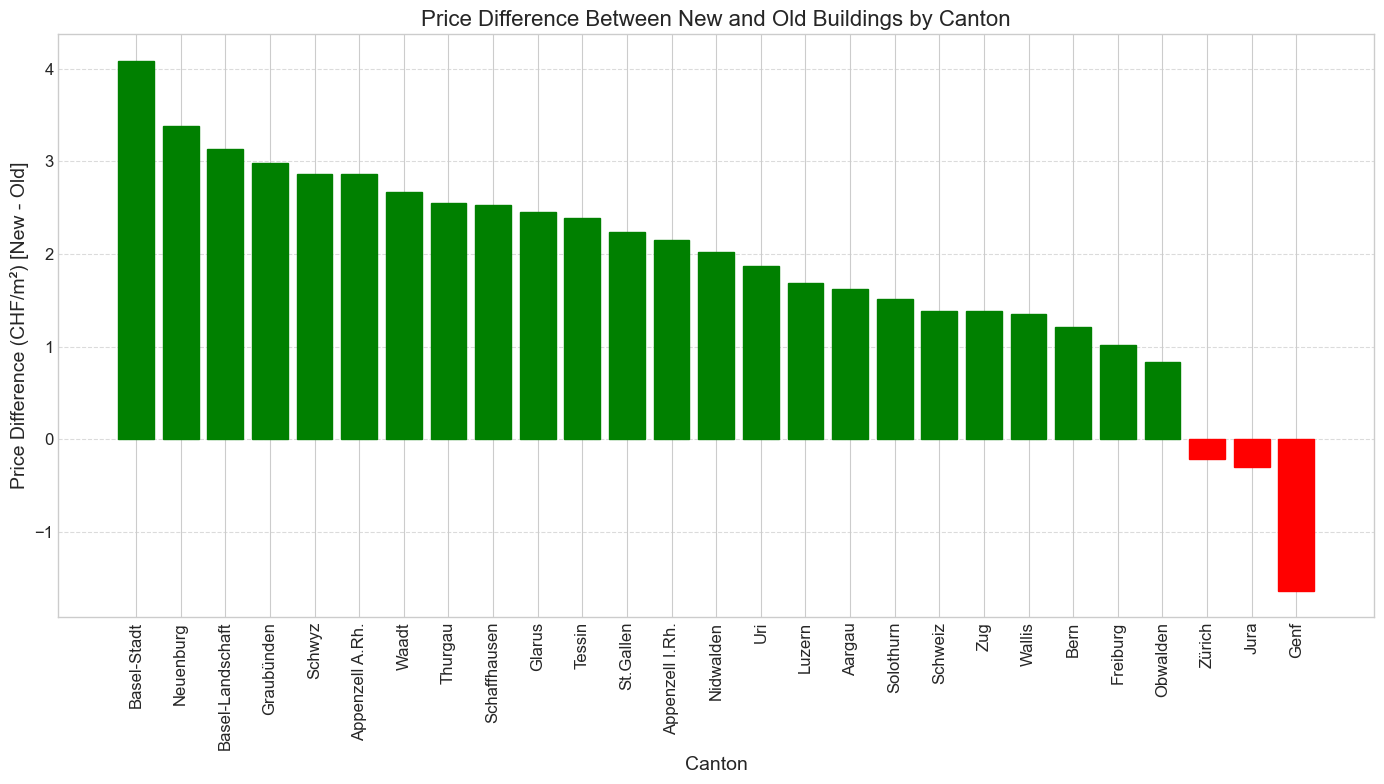

Overall average price for new buildings: CHF 17.32/m²
Overall average price for old buildings: CHF 15.46/m²
Overall price difference: CHF 1.85/m² (12.0% premium for new buildings)


In [16]:
plt.figure(figsize=(14, 8))

bars = plt.bar(comparison_df['canton'], comparison_df['price_diff'])

for i, bar in enumerate(bars):
    bar.set_color('green' if comparison_df.iloc[i]['price_diff'] > 0 else 'red')

plt.title('Price Difference Between New and Old Buildings by Canton', fontsize=16)
plt.xlabel('Canton', fontsize=14)
plt.ylabel('Price Difference (CHF/m²) [New - Old]', fontsize=14)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

overall_new_avg = new_buildings['avg_price_per_sqm'].mean()
overall_old_avg = old_buildings['avg_price_per_sqm'].mean()
overall_diff = overall_new_avg - overall_old_avg
overall_ratio = overall_new_avg / overall_old_avg

print(f"Overall average price for new buildings: CHF {overall_new_avg:.2f}/m²")
print(f"Overall average price for old buildings: CHF {overall_old_avg:.2f}/m²")
print(f"Overall price difference: CHF {overall_diff:.2f}/m² ({(overall_ratio-1)*100:.1f}% premium for new buildings)")

In [17]:
new_canton_prices = new_buildings.groupby('canton')['avg_price_per_sqm'].mean().to_dict()
old_canton_prices = old_buildings.groupby('canton')['avg_price_per_sqm'].mean().to_dict()

room_latest['est_new_price'] = room_latest.apply(
    lambda row: row['avg_price_per_sqm'] * (new_canton_prices.get(row['canton'], 1) / 
                                          old_canton_prices.get(row['canton'], 1)) 
                if row['canton'] in new_canton_prices and row['canton'] in old_canton_prices 
                else row['avg_price_per_sqm'] * (overall_new_avg / overall_old_avg),
    axis=1
)

room_latest['est_old_price'] = room_latest['avg_price_per_sqm']

new_room_prices = room_latest.groupby('room_count')['est_new_price'].mean().reset_index()
old_room_prices = room_latest.groupby('room_count')['est_old_price'].mean().reset_index()

new_cost_data = []
old_cost_data = []

for i, row in new_room_prices.iterrows():
    room_count = row['room_count']
    if room_count in typical_sizes:
        size = typical_sizes[room_count]
        new_total_rent = row['est_new_price'] * size
        old_total_rent = old_room_prices.iloc[i]['est_old_price'] * size

        new_cost_data.append({
            'room_count': room_count,
            'apartment_size': size,
            'price_per_sqm': row['est_new_price'],
            'total_monthly_rent': new_total_rent,
            'building_type': 'New'
        })

        old_cost_data.append({
            'room_count': room_count,
            'apartment_size': size,
            'price_per_sqm': old_room_prices.iloc[i]['est_old_price'],
            'total_monthly_rent': old_total_rent,
            'building_type': 'Old'
        })

new_cost_df = pd.DataFrame(new_cost_data).sort_values('apartment_size')
old_cost_df = pd.DataFrame(old_cost_data).sort_values('apartment_size')

print("Estimated costs for new buildings:")
display(new_cost_df)

print("Estimated costs for old buildings:")
display(old_cost_df)

Estimated costs for new buildings:


C:\Users\Nevin\AppData\Local\Temp\ipykernel_7404\2201267017.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  room_latest['est_new_price'] = room_latest.apply(
C:\Users\Nevin\AppData\Local\Temp\ipykernel_7404\2201267017.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  room_latest['est_old_price'] = room_latest['avg_price_per_sqm']


,room_count,apartment_size,price_per_sqm,total_monthly_rent,building_type
0,1,35,21.794635,762.812221,New
1,2,55,20.158439,1108.714121,New
2,3,75,18.260086,1369.506450,New
3,4,95,17.168736,1631.029904,New
4,5,120,16.753725,2010.446993,New
5,6+,160,17.341917,2774.706782,New


Estimated costs for old buildings:


,room_count,apartment_size,price_per_sqm,total_monthly_rent,building_type
0,1,35,19.442308,680.480769,Old
1,2,55,17.970370,988.370370,Old
2,3,75,16.270370,1220.277778,Old
3,4,95,15.288889,1452.444444,Old
4,5,120,14.914815,1789.777778,Old
5,6+,160,15.459259,2473.481481,Old


In [29]:
new_params, _ = curve_fit(cost_function, 
                         new_cost_df['apartment_size'], 
                         new_cost_df['total_monthly_rent'])

a_new_original, b_new_original, c_new_original = new_params

a_new = round(a_new_original, 3)
b_new = round(b_new_original, 1)
c_new = round(c_new_original, 0)

old_params, _ = curve_fit(cost_function, 
                         old_cost_df['apartment_size'], 
                         old_cost_df['total_monthly_rent'])

a_old_original, b_old_original, c_old_original = old_params

a_old = round(a_old_original, 3)
b_old = round(b_old_original, 1)
c_old = round(c_old_original, 0)

print(f"New buildings cost function: K_new(m²) = {a_new:.3f}·m²² + {b_new:.1f}·m² + {c_new:.0f}")
print(f"Old buildings cost function: K_old(m²) = {a_old:.3f}·m²² + {b_old:.1f}·m² + {c_old:.0f}")

print(f"New buildings marginal cost function: K'_new(m²) = {2*a_new:.3f}·m² + {b_new:.1f}")
print(f"Old buildings marginal cost function: K'_old(m²) = {2*a_old:.3f}·m² + {b_old:.1f}")

New buildings cost function: K_new(m²) = 0.024·m²² + 10.9·m² + 387
Old buildings cost function: K_old(m²) = 0.022·m²² + 9.6·m² + 349
New buildings marginal cost function: K'_new(m²) = 0.048·m² + 10.9
Old buildings marginal cost function: K'_old(m²) = 0.044·m² + 9.6


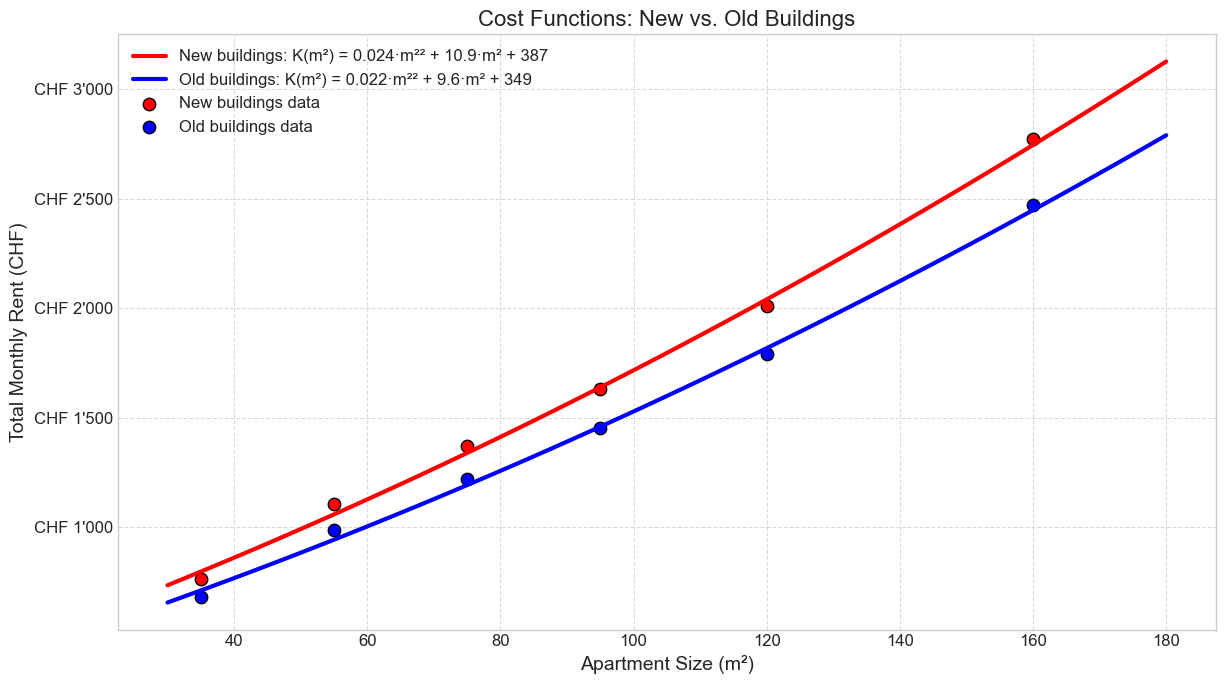

In [30]:
plt.figure(figsize=(12, 7))

x_fit = np.linspace(min(old_cost_df['apartment_size']) - 5, max(old_cost_df['apartment_size']) + 20, 100)
y_fit_new = cost_function(x_fit, a_new, b_new, c_new)
y_fit_old = cost_function(x_fit, a_old, b_old, c_old)

plt.plot(x_fit, y_fit_new, 'r-', linewidth=3, 
         label=f'New buildings: K(m²) = {a_new:.3f}·m²² + {b_new:.1f}·m² + {c_new:.0f}')
plt.plot(x_fit, y_fit_old, 'b-', linewidth=3, 
         label=f'Old buildings: K(m²) = {a_old:.3f}·m²² + {b_old:.1f}·m² + {c_old:.0f}')

plt.scatter(new_cost_df['apartment_size'], new_cost_df['total_monthly_rent'], 
            s=80, color='red', edgecolor='black', label='New buildings data')
plt.scatter(old_cost_df['apartment_size'], old_cost_df['total_monthly_rent'], 
            s=80, color='blue', edgecolor='black', label='Old buildings data')

plt.title('Cost Functions: New vs. Old Buildings', fontsize=16)
plt.xlabel('Apartment Size (m²)', fontsize=14)
plt.ylabel('Total Monthly Rent (CHF)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()

plt.gca().yaxis.set_major_formatter(FuncFormatter(chf_formatter))

plt.show()

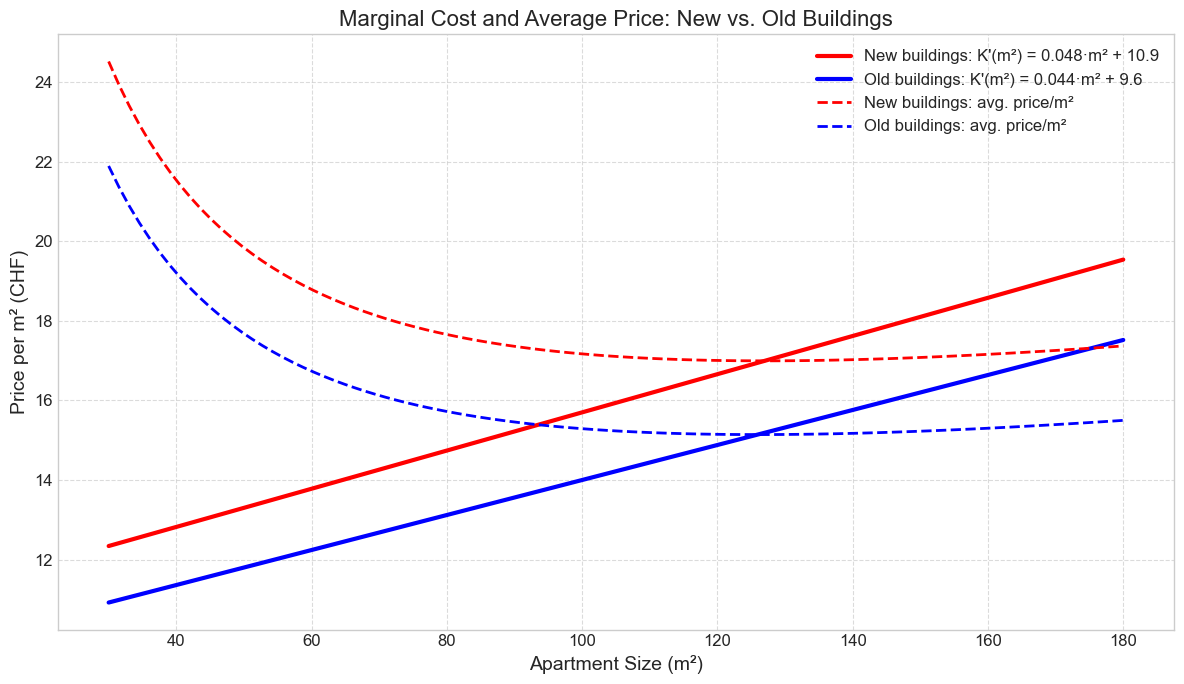

In [31]:
plt.figure(figsize=(12, 7))

marginal_cost_new = 2 * a_new * x_fit + b_new
marginal_cost_old = 2 * a_old * x_fit + b_old

plt.plot(x_fit, marginal_cost_new, 'r-', linewidth=3, 
         label=f"New buildings: K'(m²) = {2*a_new:.3f}·m² + {b_new:.1f}")
plt.plot(x_fit, marginal_cost_old, 'b-', linewidth=3, 
         label=f"Old buildings: K'(m²) = {2*a_old:.3f}·m² + {b_old:.1f}")

avg_price_new = np.array([(a_new * x**2 + b_new * x + c_new) / x for x in x_fit])
avg_price_old = np.array([(a_old * x**2 + b_old * x + c_old) / x for x in x_fit])

plt.plot(x_fit, avg_price_new, 'r--', linewidth=2, label='New buildings: avg. price/m²')
plt.plot(x_fit, avg_price_old, 'b--', linewidth=2, label='Old buildings: avg. price/m²')

plt.title('Marginal Cost and Average Price: New vs. Old Buildings', fontsize=16)
plt.xlabel('Apartment Size (m²)', fontsize=14)
plt.ylabel('Price per m² (CHF)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [21]:
try:
    crossover_size = (b_old - b_new) / (2 * (a_new - a_old))

    if 30 <= crossover_size <= 200:
        print(f"Crossover point: At {crossover_size:.1f} m², the marginal cost of an additional m² becomes equal for new and old buildings.")
        print(f"  - For apartments smaller than {crossover_size:.1f} m², the marginal cost is lower for {'old' if 2*a_old*30 + b_old < 2*a_new*30 + b_new else 'new'} buildings.")
        print(f"  - For apartments larger than {crossover_size:.1f} m², the marginal cost is lower for {'old' if 2*a_old*150 + b_old > 2*a_new*150 + b_new else 'new'} buildings.")
    else:
        small_apt = 40
        large_apt = 150

        small_mc_new = 2*a_new*small_apt + b_new
        small_mc_old = 2*a_old*small_apt + b_old

        large_mc_new = 2*a_new*large_apt + b_new
        large_mc_old = 2*a_old*large_apt + b_old

        print(f"No crossover point within reasonable apartment size range.")
        print(f"  - For small apartments (~40m²), marginal cost is lower for {'old' if small_mc_old < small_mc_new else 'new'} buildings.")
        print(f"  - For large apartments (~150m²), marginal cost is lower for {'old' if large_mc_old < large_mc_new else 'new'} buildings.")
except:
    print("Could not calculate crossover point due to numerical issues.")

No crossover point within reasonable apartment size range.
  - For small apartments (~40m²), marginal cost is lower for old buildings.
  - For large apartments (~150m²), marginal cost is lower for old buildings.


In [22]:
print("Economic efficiency analysis: Comparing one large apartment vs. multiple small ones\n")

size_4room = 95
size_2room = 55

cost_4room = cost_function(size_4room, a, b, c)
cost_2room = cost_function(size_2room, a, b, c)
cost_two_2rooms = 2 * cost_2room

avg_price_4room = cost_4room / size_4room
avg_price_2room = cost_2room / size_2room

print("Scenario 1: One 4-room apartment vs. Two 2-room apartments")
print(f"One 4-room apartment ({size_4room}m²): CHF {cost_4room:.2f} per month (CHF {avg_price_4room:.2f}/m²)")
print(f"Two 2-room apartments (2 × {size_2room}m² = {2*size_2room}m²): CHF {cost_two_2rooms:.2f} per month (CHF {avg_price_2room:.2f}/m²)")
print(f"Monthly savings with one large apartment: CHF {cost_two_2rooms - cost_4room:.2f} ({(cost_two_2rooms/cost_4room - 1)*100:.1f}% more expensive to rent two smaller apartments)")
print(f"Even though the large apartment is {size_4room}m² vs. {2*size_2room}m² for two small ones ({(1 - size_4room/(2*size_2room))*100:.1f}% less space)")

size_5room = 120
size_2room = 55

cost_5room = cost_function(size_5room, a, b, c)
cost_2room = cost_function(size_2room, a, b, c)
cost_three_2rooms = 3 * cost_2room

avg_price_5room = cost_5room / size_5room
avg_price_2room = cost_2room / size_2room

print("\nScenario 2: One 5-room apartment vs. Three 2-room apartments")
print(f"One 5-room apartment ({size_5room}m²): CHF {cost_5room:.2f} per month (CHF {avg_price_5room:.2f}/m²)")
print(f"Three 2-room apartments (3 × {size_2room}m² = {3*size_2room}m²): CHF {cost_three_2rooms:.2f} per month (CHF {avg_price_2room:.2f}/m²)")
print(f"Monthly savings with one large apartment: CHF {cost_three_2rooms - cost_5room:.2f} ({(cost_three_2rooms/cost_5room - 1)*100:.1f}% more expensive to rent three smaller apartments)")
print(f"Even though the large apartment is {size_5room}m² vs. {3*size_2room}m² for three small ones ({(1 - size_5room/(3*size_2room))*100:.1f}% less space)")

Economic efficiency analysis: Comparing one large apartment vs. multiple small ones

Scenario 1: One 4-room apartment vs. Two 2-room apartments
One 4-room apartment (95m²): CHF 1459.55 per month (CHF 15.36/m²)
Two 2-room apartments (2 × 55m² = 110m²): CHF 1887.10 per month (CHF 17.16/m²)
Monthly savings with one large apartment: CHF 427.55 (29.3% more expensive to rent two smaller apartments)
Even though the large apartment is 95m² vs. 110m² for two small ones (13.6% less space)

Scenario 2: One 5-room apartment vs. Three 2-room apartments
One 5-room apartment (120m²): CHF 1817.80 per month (CHF 15.15/m²)
Three 2-room apartments (3 × 55m² = 165m²): CHF 2830.65 per month (CHF 17.16/m²)
Monthly savings with one large apartment: CHF 1012.85 (55.7% more expensive to rent three smaller apartments)
Even though the large apartment is 120m² vs. 165m² for three small ones (27.3% less space)


In [23]:
breakeven_size = np.sqrt(abs(c/a))

print(f"Break-even analysis: At what point does increasing apartment size no longer provide economic benefit?\n")
print(f"At approximately {breakeven_size:.1f} m², the marginal cost equals the average cost per m².")
print(f"This means:")
print(f"  - For apartments smaller than {breakeven_size:.1f} m², each additional m² costs less than the average cost.")
print(f"  - For apartments larger than {breakeven_size:.1f} m², each additional m² costs more than the average cost.")
print(f"  - The economically optimal apartment size (from a pure cost perspective) is around {breakeven_size:.1f} m².")

breakeven_marginal_cost = 2*a*breakeven_size + b
breakeven_average_cost = (a*breakeven_size**2 + b*breakeven_size + c) / breakeven_size

print(f"\nAt the break-even point:")
print(f"  - Marginal cost: CHF {breakeven_marginal_cost:.2f} per additional m²")
print(f"  - Average cost: CHF {breakeven_average_cost:.2f} per m²")

closest_room_size = min(typical_sizes.items(), key=lambda x: abs(float(x[1]) - breakeven_size))
print(f"\nThe economically optimal apartment size corresponds most closely to a {closest_room_size[0]}-room apartment.")

Break-even analysis: At what point does increasing apartment size no longer provide economic benefit?

At approximately 126.0 m², the marginal cost equals the average cost per m².
This means:
  - For apartments smaller than 126.0 m², each additional m² costs less than the average cost.
  - For apartments larger than 126.0 m², each additional m² costs more than the average cost.
  - The economically optimal apartment size (from a pure cost perspective) is around 126.0 m².

At the break-even point:
  - Marginal cost: CHF 15.14 per additional m²
  - Average cost: CHF 15.14 per m²

The economically optimal apartment size corresponds most closely to a 5+-room apartment.


<Figure size 2000x1000 with 0 Axes>

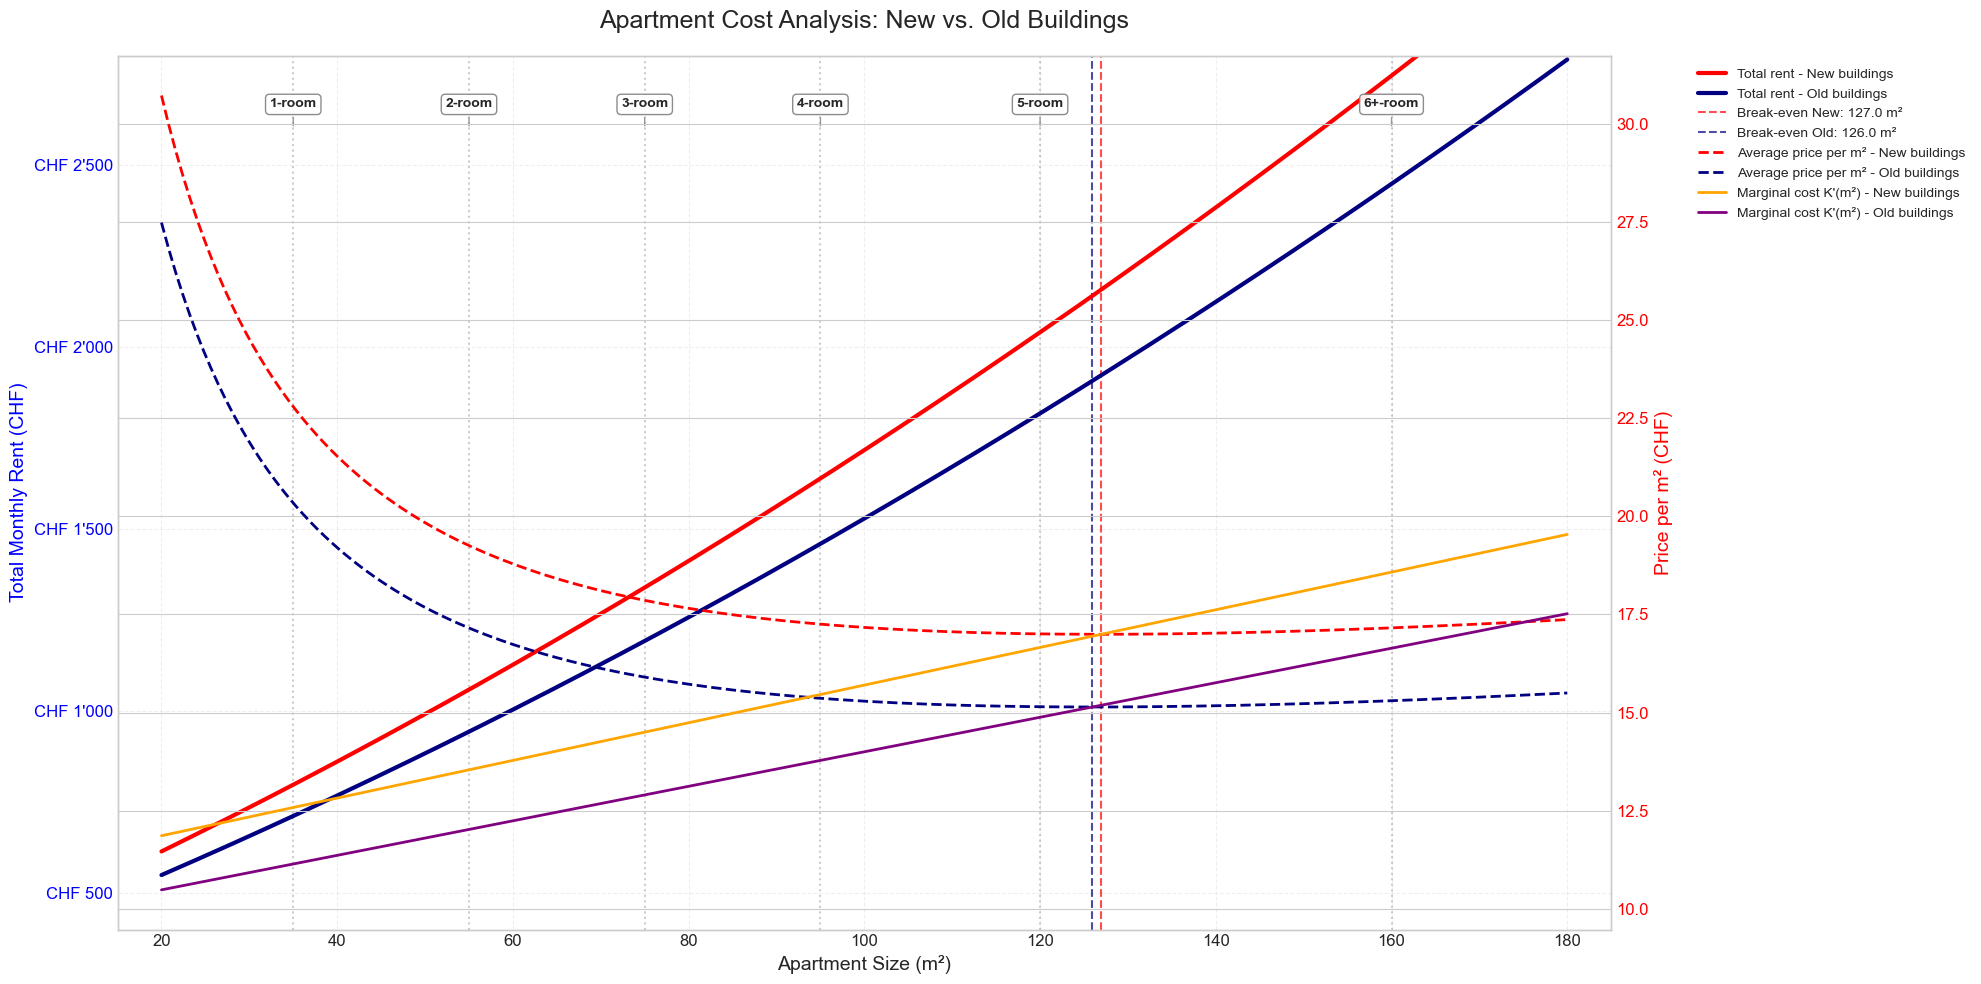

In [36]:
plt.figure(figsize=(20, 10))

sizes = np.linspace(20, 180, 200)

total_costs_new = cost_function(sizes, a_new, b_new, c_new)
total_costs_old = cost_function(sizes, a_old, b_old, c_old)
average_costs_new = total_costs_new / sizes
average_costs_old = total_costs_old / sizes
marginal_costs_new = 2*a_new*sizes + b_new
marginal_costs_old = 2*a_old*sizes + b_old

fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()

total_cost_new_line = ax1.plot(sizes, total_costs_new, 'r-', linewidth=3,
                 label='Total rent - New buildings', zorder=4)
total_cost_old_line = ax1.plot(sizes, total_costs_old, 'navy', linewidth=3,
                 label='Total rent - Old buildings', zorder=4)

ax1.set_xlabel('Apartment Size (m²)', fontsize=14)
ax1.set_ylabel('Total Monthly Rent (CHF)', fontsize=14, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.yaxis.set_major_formatter(FuncFormatter(chf_formatter))

avg_cost_new_line = ax2.plot(sizes, average_costs_new, 'r--', linewidth=2,
                 label='Average price per m² - New buildings', zorder=3)
avg_cost_old_line = ax2.plot(sizes, average_costs_old, 'navy', linestyle='--', linewidth=2,
                 label='Average price per m² - Old buildings', zorder=3)

marginal_cost_new_line = ax2.plot(sizes, marginal_costs_new, 'orange', linewidth=2,
                    label='Marginal cost K\'(m²) - New buildings', zorder=3)
marginal_cost_old_line = ax2.plot(sizes, marginal_costs_old, 'purple', linewidth=2,
                    label='Marginal cost K\'(m²) - Old buildings', zorder=3)

ax2.set_ylabel('Price per m² (CHF)', fontsize=14, color='red')
ax2.tick_params(axis='y', labelcolor='red')

breakeven_size_new = np.sqrt(abs(c_new/a_new))
breakeven_size_old = np.sqrt(abs(c_old/a_old))

breakeven_new_line = ax1.axvline(x=breakeven_size_new, color='red', linestyle='--', alpha=0.7,
                  label=f'Break-even New: {breakeven_size_new:.1f} m²', zorder=2)
breakeven_old_line = ax1.axvline(x=breakeven_size_old, color='navy', linestyle='--', alpha=0.7,
                  label=f'Break-even Old: {breakeven_size_old:.1f} m²', zorder=2)

room_sizes = [(f"{key}-room", val) for key, val in typical_sizes.items() if key in ['1', '2', '3', '4', '5', '6+']]
room_sizes.sort(key=lambda x: x[1])

label_height = 2600

for label, size in room_sizes:
    ax1.axvline(x=size, color='gray', linestyle=':', alpha=0.4, zorder=1)
    
    ax1.annotate(label, xy=(size, label_height), xytext=(size, label_height + 50),
                fontsize=10, ha='center', va='bottom', weight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9, edgecolor='gray'),
                arrowprops=dict(arrowstyle='-', color='gray', alpha=0.8, lw=1), zorder=6)

lines1 = total_cost_new_line + total_cost_old_line + [breakeven_new_line, breakeven_old_line]
lines2 = avg_cost_new_line + avg_cost_old_line + marginal_cost_new_line + marginal_cost_old_line
lines = lines1 + lines2
labels = [l.get_label() for l in lines]

ax1.legend(lines, labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, framealpha=0.95)

plt.title('Apartment Cost Analysis: New vs. Old Buildings', fontsize=18, pad=20)
ax1.grid(True, linestyle='--', alpha=0.3, zorder=0)
ax1.set_xlim(15, 185)
ax1.set_ylim(400, 2800)
plt.tight_layout()
plt.show()

In [25]:
print("# Swiss Rental Market Analysis: How Costs Change per Additional Square Meter\n")
print("## Key Findings\n")

print("### 1. Cost Function")
print(f"- We modeled the monthly rental cost function as: K(m²) = {a:.3f}·m²² + {b:.1f}·m² + {c:.0f}")
print(f"- This function shows how the total monthly rent changes with apartment size")
print(f"- The R² value of {r_squared:.4f} indicates a strong fit to our data\n")

print("### 2. Marginal Cost Function")
print(f"- The marginal cost function (cost of an additional m²) is: K'(m²) = {2*a:.3f}·m² + {b:.1f}")
print(f"- This shows that the cost of an additional square meter increases with apartment size")
print(f"- For small apartments (~40m²), an additional m² costs about CHF {2*a*40 + b:.2f}")
print(f"- For large apartments (~150m²), an additional m² costs about CHF {2*a*150 + b:.2f}\n")

print("### 3. Diminishing Marginal Utility")
print(f"- The analysis confirms the principle of diminishing marginal utility in housing")
print(f"- The average price per m² decreases as apartment size increases")
print(f"- The break-even point where marginal cost equals average cost is at {breakeven_size:.1f} m²")
print(f"- This suggests that the most economically efficient apartment size is around {breakeven_size:.1f} m²\n")

print("### 4. New vs. Old Buildings")
if a_new > a_old:
    print(f"- The cost function for new buildings increases more rapidly with size")
    print(f"- This means the premium for new buildings is more pronounced in larger apartments")
else:
    print(f"- The cost function for old buildings increases more rapidly with size")
    print(f"- This means the premium for new buildings is more pronounced in smaller apartments")

print(f"- On average, new buildings command a {(overall_ratio-1)*100:.1f}% premium over old buildings")
print(f"- This premium varies significantly by canton, ranging from {comparison_df['price_ratio'].min()*100-100:.1f}% to {comparison_df['price_ratio'].max()*100-100:.1f}%\n")

print("### 5. Economic Efficiency of Larger Apartments")
print(f"- Renting one large apartment is more cost-effective than multiple smaller ones")
print(f"- For example, one 4-room apartment (95m²) is about {(cost_two_2rooms/cost_4room - 1)*100:.1f}% cheaper than two 2-room apartments")
print(f"- This efficiency comes from the decreasing average cost per m² as apartment size increases\n")

print("## Practical Implications\n")
print("1. For Renters: When looking for housing, consider that larger apartments generally offer better value per square meter. The optimal economic choice appears to be around a {}-room apartment.".format(closest_room_size[0]))
print("2. For Investors: The marginal cost function suggests where the economic value of additional space begins to diminish, informing optimal apartment sizing for new developments.")
print("3. For Policymakers: Understanding the cost structure of housing can help in designing more effective affordable housing policies.")
print("4. For Urban Planners: The differential in costs between new and old buildings across cantons provides insights into regional housing market dynamics.\n")

print("## Limitations\n")
print("1. Data Approximation: The analysis relies on average prices that may not reflect specific local conditions or quality variations.")
print("2. Model Simplifications: The quadratic cost function simplifies the real-world relationship between size and rent.")
print("3. Indirect Comparisons: The new vs. old building comparison is based on construction period data that was not directly linked to room count data.")
print("4. Typical Sizes: The analysis uses approximated typical sizes for different room counts, which may vary in practice.")

# Swiss Rental Market Analysis: How Costs Change per Additional Square Meter

## Key Findings

### 1. Cost Function
- We modeled the monthly rental cost function as: K(m²) = 0.022·m²² + 9.6·m² + 349
- This function shows how the total monthly rent changes with apartment size
- The R² value of 0.9974 indicates a strong fit to our data

### 2. Marginal Cost Function
- The marginal cost function (cost of an additional m²) is: K'(m²) = 0.044·m² + 9.6
- This shows that the cost of an additional square meter increases with apartment size
- For small apartments (~40m²), an additional m² costs about CHF 11.36
- For large apartments (~150m²), an additional m² costs about CHF 16.20

### 3. Diminishing Marginal Utility
- The analysis confirms the principle of diminishing marginal utility in housing
- The average price per m² decreases as apartment size increases
- The break-even point where marginal cost equals average cost is at 126.0 m²
- This suggests that the most economically efficient apart